In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import sys
from time import sleep

import numpy as np

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP

from sklearn.metrics import accuracy_score, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#from utils import read_ZINC_smiles, smiles_to_onehot, partition, OneHotLogPDataSet
from tqdm import tnrange, tqdm_notebook
import pandas as pd
import seaborn as sns

In [3]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.15
args.test_size = 0.15
args.shuffle = True

In [4]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

## 1. Pre-Processing

In [5]:
def read_ZINC_smiles(file_name, num_mol):
    f = open(file_name, 'r')
    contents = f.readlines()

    smi_list = []
    logP_list = []

    for i in tqdm_notebook(range(num_mol), desc='Reading Data'):
        smi = contents[i].strip()
        m = Chem.MolFromSmiles(smi)
        smi_list.append(smi)
        logP_list.append(MolLogP(m))

    logP_list = np.asarray(logP_list).astype(float)

    return smi_list, logP_list


def smiles_to_onehot(smi_list):
    def smiles_to_vector(smiles, vocab, max_length):
        while len(smiles) < max_length:
            smiles += " "
        vector = [vocab.index(str(x)) for x in smiles]
        one_hot = np.zeros((len(vocab), max_length), dtype=int)
        for i, elm in enumerate(vector):
            one_hot[elm][i] = 1
        return one_hot

    vocab = np.load('./vocab.npy')
    smi_total = []

    for i, smi in tqdm_notebook(enumerate(smi_list), desc='Converting to One Hot'):
        smi_onehot = smiles_to_vector(smi, list(vocab), 120)
        smi_total.append(smi_onehot)

    return np.asarray(smi_total)

def convert_to_graph(smiles_list):
    adj = []
    adj_norm = []
    features = []
    maxNumAtoms = 50
    for i in tqdm_notebook(smiles_list, desc='Converting to Graph'):
        # Mol
        iMol = Chem.MolFromSmiles(i.strip())
        #Adj
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        # Feature
        if( iAdjTmp.shape[0] <= maxNumAtoms):
            # Feature-preprocessing
            iFeature = np.zeros((maxNumAtoms, 58))
            iFeatureTmp = []
            for atom in iMol.GetAtoms():
                iFeatureTmp.append( atom_feature(atom) ) ### atom features only
            iFeature[0:len(iFeatureTmp), 0:58] = iFeatureTmp ### 0 padding for feature-set
            features.append(iFeature)

            # Adj-preprocessing
            iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
    features = np.asarray(features)

    return features, adj
    
def atom_feature(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                       'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                       'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    [atom.GetIsAromatic()])    # (40, 6, 5, 6, 1)

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    #print list((map(lambda s: x == s, allowable_set)))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


class GCNDataset(Dataset):
    def __init__(self, list_feature, list_adj, list_logP):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_logP = list_logP

    def __len__(self):
        return len(self.list_feature)

    def __getitem__(self, index):
        return self.list_feature[index], self.list_adj[index], self.list_logP[index]


def partition(list_feature, list_adj, list_logP, args):
    num_total = list_feature.shape[0]
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)

    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    logP_train = list_logP[:num_train]
    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    logP_val = list_logP[num_train:num_train + num_val]
    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_train:num_train + num_val]
    logP_test = list_logP[num_total - num_test:]

    train_set = GCNDataset(feature_train, adj_train, logP_train)
    val_set = GCNDataset(feature_val, adj_val, logP_val)
    test_set = GCNDataset(feature_test, adj_test, logP_test)

    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

In [14]:
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 20000)
list_feature, list_adj = convert_to_graph(list_smi)
args.dict_partition = partition(list_feature, list_adj, list_logP, args)

## 2. Model Construction

In [15]:
class GatedSkipConnection(nn.Module):
    
    def __init__(self, in_dim, new_dim, out_dim, activation):
        super(GatedSkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.new_dim = new_dim
        self.out_dim = out_dim
        self.activation = activation
        
        self.linear_in = nn.Linear(in_dim, out_dim)
        self.linear_new = nn.Linear(new_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_x, new_x):        
        z = self.gate_coefficient(input_x, new_x)
        
        if (self.in_dim != self.out_dim):
            input_x = self.linear_in(input_x)
        if (self.new_dim != self.out_dim):
            new_x = self.linear_new(new_x)
            
        out = torch.mul(new_x, z) + torch.mul(input_x, 1.0-z)
        
        
        
        return out
        
    def gate_coefficient(self, input_x, new_x):
        X1 = self.linear_in(input_x)
        X2 = self.linear_new(new_x)
        gate_coefficient = self.sigmoid(X1 + X2)
        
        return gate_coefficient

In [16]:
class GraphConvolution(nn.Module):
    
    def __init__(self, in_dim, hidden_dim, activation, sc='no'):
        super(GraphConvolution, self).__init__()
        
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.sc = sc

        self.linear = nn.Linear(self.in_dim, 
                                self.hidden_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.gated_skip_connection = GatedSkipConnection(self.in_dim,
                                                         self.hidden_dim,
                                                         self.hidden_dim, 
                                                         self.activation)
        
    def forward(self, x, adj):
        out = self.linear(x)
        out = torch.matmul(adj, out)
        
        if (self.sc == 'gsc'):
            out = self.gated_skip_connection(x, out)
        elif (self.sc == 'no'):
            out = self.activation(out)
        else:
            out = self.activation(out)
        
        return out
        

In [17]:
class ReadOut(nn.Module):
    
    def __init__(self, in_dim, out_dim, activation):
        super(ReadOut, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim= out_dim
        
        self.linear = nn.Linear(self.in_dim, 
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = activation

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, dim=1)
        out = self.activation(out)
        
        return out

In [18]:
class Predictor(nn.Module):
    
    def __init__(self, in_dim, out_dim, activation=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = activation
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        
        return out

In [19]:
class LogPPredictor(nn.Module):
    
    def __init__(self, 
                 n_layer, 
                 in_dim, 
                 hidden_dim_1, 
                 hidden_dim_2,
                 out_dim,
                 sc='no'):
        super(LogPPredictor, self).__init__()
        
        self.n_layer = n_layer
        self.graph_convolution_1 = GraphConvolution(in_dim, hidden_dim_1, nn.ReLU(), sc)
        self.graph_convolution_2 = GraphConvolution(hidden_dim_1, hidden_dim_1, nn.ReLU(), sc)
        self.readout = ReadOut(hidden_dim_1, hidden_dim_2, nn.Sigmoid())
        self.predictor_1 = Predictor(hidden_dim_2, hidden_dim_2, nn.ReLU())
        self.predictor_2 = Predictor(hidden_dim_2, hidden_dim_2, nn.Tanh())
        self.predictor_3 = Predictor(hidden_dim_2, out_dim)
    
    def forward(self, x, adj):
        out = self.graph_convolution_1(x, adj)
        for i in range(self.n_layer-1):
            out = self.graph_convolution_2(out, adj)
        out = self.readout(out)
        out = self.predictor_1(out)
        out = self.predictor_2(out)
        out = self.predictor_3(out)
        
        return out  

In [20]:
args.batch_size = 10
args.lr = 0.001
args.l2_coef = 0.001
args.optim = optim.Adam
args.criterion = nn.MSELoss()
args.epoch = 10
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
use_gpu = lambda x=True: torch.set_default_tensor_type(torch.cuda.DoubleTensor if torch.cuda.is_available() and x else torch.FloatTensor)
use_gpu()

print(args.device)

model = LogPPredictor(1, 58, 64, 128, 1, 'gsc')
model.to(args.device)
model.cuda()

list_train_loss = list()
list_val_loss = list()
acc = 0
mse = 0

optimizer = args.optim(model.parameters(),
                       lr=args.lr,
                       weight_decay=args.l2_coef)

data_train = DataLoader(args.dict_partition['train'], 
                        batch_size=args.batch_size,
                        shuffle=args.shuffle)

data_val = DataLoader(args.dict_partition['val'],
                     batch_size=args.batch_size,
                     shuffle=args.shuffle)

for epoch in tqdm_notebook(range(args.epoch), desc='Epoch'):
    model.train()
    epoch_train_loss = 0
    for i, batch in enumerate(data_train):
        list_feature = torch.tensor(batch[0])
        list_adj = torch.tensor(batch[1])
        list_logP = torch.tensor(batch[2])
        list_logP = list_logP.view(-1,1)
        list_feature, list_adj, list_logP = list_feature.to(args.device), list_adj.to(args.device), list_logP.to(args.device)
        
        optimizer.zero_grad()
        list_pred_logP = model(list_feature, list_adj)
        list_pred_logP.require_grad = False
        train_loss = args.criterion(list_pred_logP, list_logP)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
        
    list_train_loss.append(epoch_train_loss/len(data_train))
    
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            list_feature = torch.tensor(batch[0])
            list_adj = torch.tensor(batch[1])
            list_logP = torch.tensor(batch[2])
            list_logP = list_logP.view(-1,1)
            list_feature, list_adj, list_logP = list_feature.to(args.device), list_adj.to(args.device), list_logP.to(args.device)


            list_pred_logP = model(list_feature, list_adj)
            val_loss = args.criterion(list_pred_logP, list_logP)
            epoch_val_loss += val_loss.item()
        
    list_val_loss.append(epoch_val_loss/len(data_val))
    
data_test = DataLoader(args.dict_partition['test'],
                       batch_size=args.batch_size,
                       shuffle=args.shuffle)

model.eval()
with torch.no_grad():
    logP_total = list()
    pred_logP_total = list()
    for i, batch in enumerate(data_val):
        list_feature = torch.tensor(batch[0])
        list_adj = torch.tensor(batch[1])
        list_logP = torch.tensor(batch[2])
        logP_total += list_logP.tolist()
        list_logP = list_logP.view(-1,1)
        list_feature, list_adj, list_logP = list_feature.to(args.device), list_adj.to(args.device), list_logP.to(args.device)

        
        list_pred_logP = model(list_feature, list_adj)
        
        pred_logP_total += list_pred_logP.tolist()
    
    mse = mean_squared_error(logP_total, pred_logP_total)

cuda


Text(0.5, 0, 'Epoch')

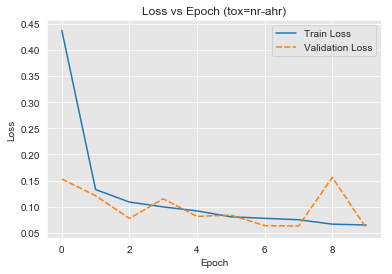

In [22]:
data = np.vstack((list_train_loss, list_val_loss))
data = np.transpose(data)
epochs = np.arange(args.epoch)
df_loss = pd.DataFrame(data, epochs, ["Train Loss", "Validation Loss"])

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
grid = sns.lineplot(data=df_loss)
grid.set_title("Loss vs Epoch (tox=nr-ahr)")
grid.set_ylabel("Loss")
grid.set_xlabel("Epoch")

In [23]:
next(model.parameters()).is_cuda

True

In [22]:
model = LogPPredictor(1, 58, 64, 128, 1, 'gsc')
model.cuda()

list_train_loss = list()
list_val_loss = list()
acc = 0
mse = 0

optimizer = args.optim(model.parameters(),
                       lr=args.lr,
                       weight_decay=args.l2_coef)

data_train = DataLoader(args.dict_partition['train'], 
                        batch_size=args.batch_size,
                        pin_memory=True,
                        shuffle=args.shuffle)

data_val = DataLoader(args.dict_partition['val'],
                     batch_size=args.batch_size,
                     pin_memory=True,
                     shuffle=args.shuffle)

for epoch in tqdm_notebook(range(args.epoch), desc='Epoch'):
    model.train()
    epoch_train_loss = 0
    for i, batch in enumerate(data_train):
        list_feature = torch.tensor(batch[0]).cuda()
        list_adj = torch.tensor(batch[1]).cuda()
        list_logP = torch.tensor(batch[2]).cuda()
        list_logP = list_logP.view(-1,1)
        
        optimizer.zero_grad()
        list_pred_logP = model(list_feature, list_adj)
        list_pred_logP.require_grad = False
        train_loss = args.criterion(list_pred_logP, list_logP)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
        
    list_train_loss.append(epoch_train_loss/len(data_train))
    
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            list_feature = torch.tensor(batch[0]).cuda()
            list_adj = torch.tensor(batch[1]).cuda()
            list_logP = torch.tensor(batch[2]).cuda()
            list_logP = list_logP.view(-1,1)


            list_pred_logP = model(list_feature, list_adj)
            val_loss = args.criterion(list_pred_logP, list_logP)
            epoch_val_loss += val_loss.item()
        
    list_val_loss.append(epoch_val_loss/len(data_val))
    
data_test = DataLoader(args.dict_partition['test'],
                       batch_size=args.batch_size,
                       pin_memory=True,
                       shuffle=args.shuffle)

model.eval()
with torch.no_grad():
    logP_total = list()
    pred_logP_total = list()
    for i, batch in enumerate(data_val):
        list_feature = torch.tensor(batch[0]).cuda()
        list_adj = torch.tensor(batch[1]).cuda()
        list_logP = torch.tensor(batch[2]).cuda()
        logP_total += list_logP.tolist()
        list_logP = list_logP.view(-1,1)

        
        list_pred_logP = model(list_feature, list_adj)
        
        pred_logP_total += list_pred_logP.tolist()
    
    mse = mean_squared_error(logP_total, pred_logP_total)

Text(0.5, 0, 'Epoch')

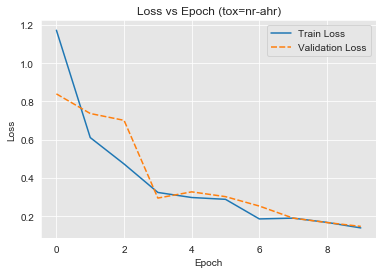

In [17]:
data = np.vstack((list_train_loss, list_val_loss))
data = np.transpose(data)
epochs = np.arange(args.epoch)
df_loss = pd.DataFrame(data, epochs, ["Train Loss", "Validation Loss"])

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
grid = sns.lineplot(data=df_loss)
grid.set_title("Loss vs Epoch (tox=nr-ahr)")
grid.set_ylabel("Loss")
grid.set_xlabel("Epoch")

In [ ]:
for i in tqdm_notebook(range(10), desc='1', leave=True, position=1):
    for j in tqdm_notebook(range(100), desc='2', leave=False, position=2):
        sleep(0.01)